In [1]:
import os
import sys

sys.path.insert(0, os.path.relpath("../../../../.."))

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import (
    SuperSimulationFactory,
)
from recidiviz.calculator.modeling.population_projection.transition_table import (
    TransitionTable,
)
from recidiviz.calculator.modeling.population_projection.shell_compartment import (
    ShellCompartment,
)
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from functools import partial
import yaml

In [2]:
%run ../../../../../../recidiviz-research/utils/research_utils.py

/Users/justine/recidiviz-research/utils/research_utils.py:37: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext google.cloud.bigquery")
/Users/justine/recidiviz-research/utils/research_utils.py:38: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/Users/justine/recidiviz-research/utils/research_utils.py:39: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")  # 2 => reload ALL modules on every code run


In [3]:
adjust_plot_scale(0.4)

In [31]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/OK/OK_SB_1646_sentence_reclassification/OK_SB_1646_model_inputs.yaml"
)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1501.31rows/s]


initialization time:  2.3577778339385986
simulation_time:  2.623486042022705


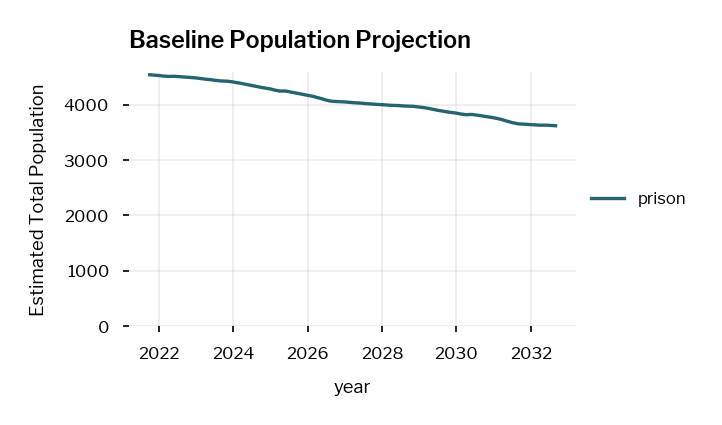

In [32]:
policy_sim.simulate_baseline(["prison"])
add_legend()

In [33]:
data_inputs = policy_sim.initializer.get_data_inputs()
baseline_projection = policy_sim.get_population_simulations()[
    "baseline_projections"
].get_population_projections()
baseline_outflows = policy_sim.get_population_simulations()[
    "baseline_projections"
].get_outflows()
baseline_outflows.head()

total_population compartment simulation_group
outflow_to time_step                                               
prison     -133                  205.0    pretrial                x
           -132                  205.0    pretrial                x
           -131                  205.0    pretrial                x
           -130                  205.0    pretrial                x
           -129                  205.0    pretrial                x

In [34]:
data_inputs.total_population_data.sort_values(by="time_step").head()

,simulation_tag,time_step,compartment,total_population,crime,crime_type,age,race,date_created
16,OK_SB1646,-35,prison,5734.0,None,x,None,None,2022-03-24 16:34:44.611726+00:00
13,OK_SB1646,-34,prison,5683.0,None,x,None,None,2022-03-24 16:34:44.611726+00:00
4,OK_SB1646,-33,prison,5645.0,None,x,None,None,2022-03-24 16:34:44.611726+00:00
34,OK_SB1646,-32,prison,5605.0,None,x,None,None,2022-03-24 16:34:44.611726+00:00
28,OK_SB1646,-31,prison,5577.0,None,x,None,None,2022-03-24 16:34:44.611726+00:00


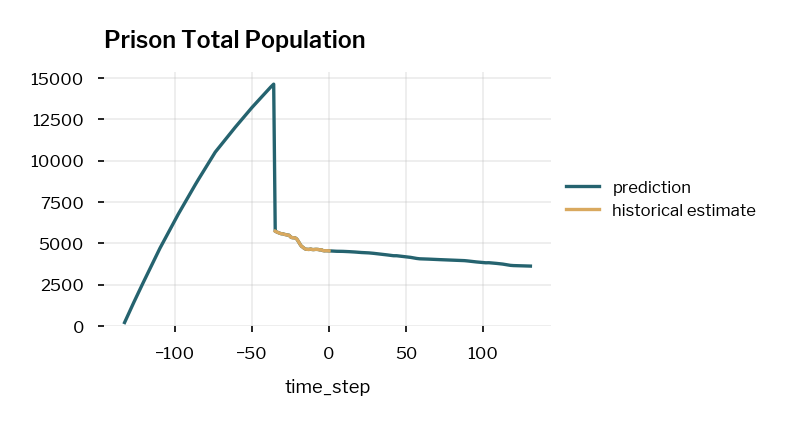

In [35]:
total_population = data_inputs.total_population_data
for compartment, df in baseline_projection.groupby("compartment"):
    if "release" in compartment:
        continue
    plt.figure()
    df.set_index(["time_step"])["total_population"].plot(label="prediction")

    compartment_pop = total_population[total_population["compartment"] == compartment]
    compartment_pop.groupby(["time_step"])["total_population"].sum().plot(
        label="historical estimate"
    )

    add_legend()
    plt.title(f"{compartment.title()} Total Population")
    plt.ylim([0, None])

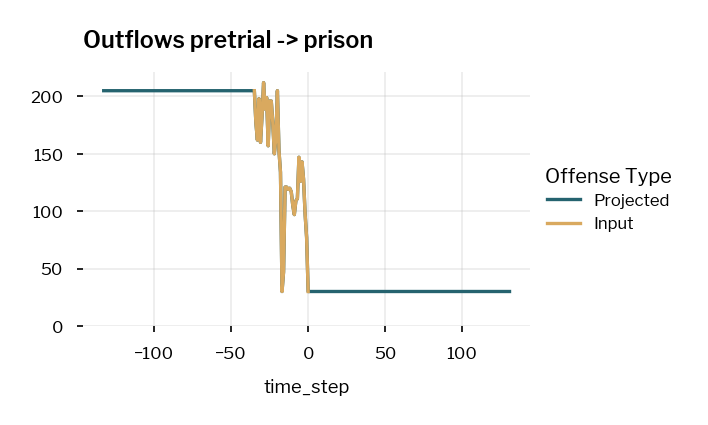

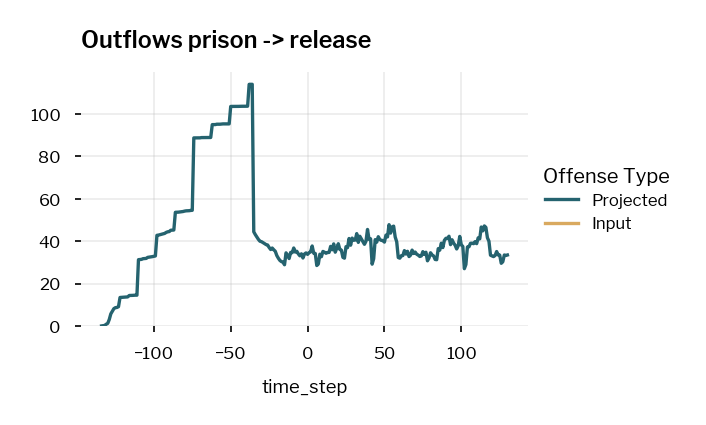

In [36]:
outflows = data_inputs.outflows_data
for (compartment, outflow_to), df in baseline_outflows.groupby(
    ["compartment", "outflow_to"]
):
    if compartment == "release":
        continue
    plt.figure()
    ax = df.reset_index("outflow_to")["total_population"].plot(label="Projected")

    historical_outflows = outflows[
        (outflows["compartment"] == compartment)
        & (outflows["outflow_to"] == outflow_to)
    ]
    historical_outflows.plot(x="time_step", y="total_population", ax=ax, label="Input")

    add_legend(title="Offense Type")
    plt.title(f"Outflows {compartment} -> {outflow_to}")
    plt.ylim([0, None])

In [37]:
policy_transitions = pd.read_csv(
    "../state/OK/OK_SB_1646_sentence_reclassification/v3/trans_policy_v3 - trans_policy_v3.csv"
)
policy_transitions.rename(
    {"new_sent": "compartment_duration", "n": "total_population"}, axis=1, inplace=True
)
alternate_policy_transitions = policy_transitions.copy()
alternate_policy_transitions["compartment_duration"] = np.floor(
    np.clip(alternate_policy_transitions["compartment_duration"], a_min=1, a_max=None)
)
alternate_policy_transitions = alternate_policy_transitions.groupby(
    ["compartment", "outflow_to", "compartment_duration", "crime_type"], as_index=False
)[["total_population"]].sum()
alternate_policy_transitions.head()

,compartment,outflow_to,compartment_duration,crime_type,total_population
0,prison,release,1.0,x,221
1,prison,release,2.0,x,17
2,prison,release,3.0,x,29
3,prison,release,4.0,x,63
4,prison,release,5.0,x,58


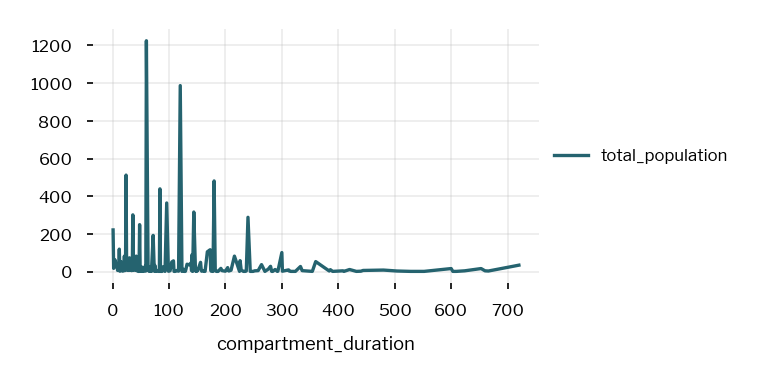

In [38]:
alternate_policy_transitions[
    alternate_policy_transitions["compartment"] == "prison"
].groupby(["compartment_duration"])["total_population"].sum().plot()
add_legend()

In [39]:
# Simulate policy starting July 1, 2022
policy_ts = 9

# Policy functions


def replace_sentencing_matrix():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_policy_transitions,
        retroactive=False,
    )


policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(),
        spark_compartment="prison",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
]

initialization time:  2.3136422634124756
initialization time:  2.2319278717041016
simulation_time:  2.388399839401245
simulation_time:  2.387406826019287
4995.1


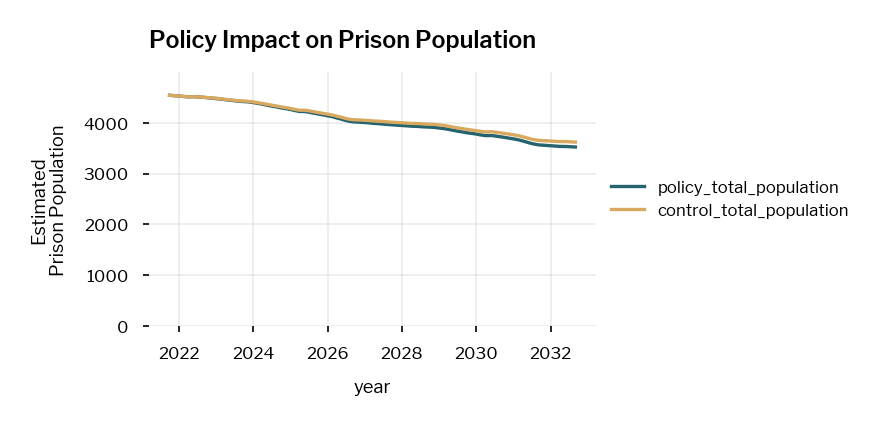

In [40]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

initialization time:  2.227938652038574
initialization time:  2.227891206741333
simulation_time:  2.63124680519104
simulation_time:  2.7533581256866455
4999.759526021927


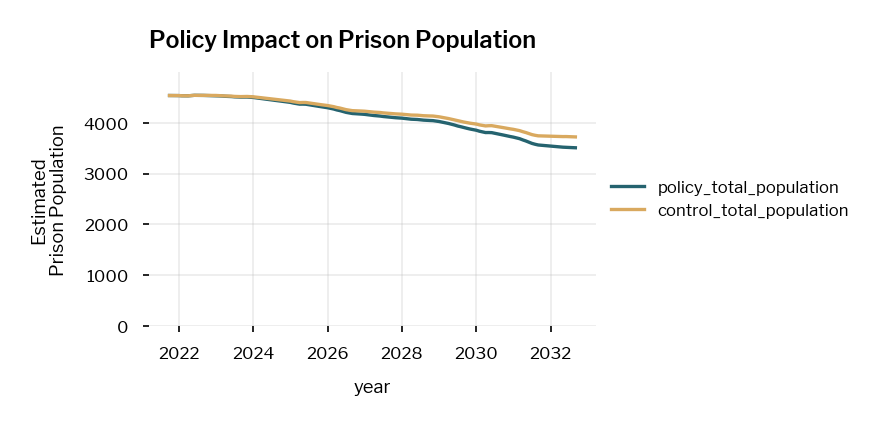

In [26]:
policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [41]:
simulation_tag = "OK_SB1646"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3253.92it/s]


policy_ts 9


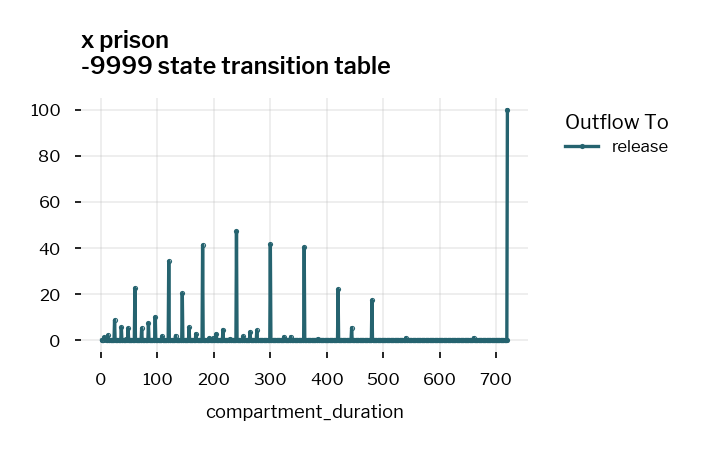

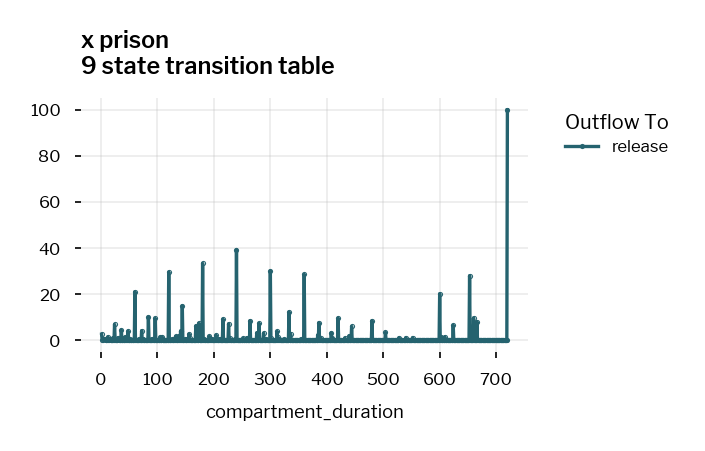

In [42]:
simulation_key = "policy"
compartment = "prison"
for age, sub_sim in policy_sim.get_population_simulations()[
    simulation_key
].sub_simulations.items():
    spark_compartment = sub_sim.simulation_compartments[compartment]

    policy_ts = max(spark_compartment.compartment_transitions.transition_tables.keys())
    print(f"policy_ts {policy_ts}")
    for (
        time_step,
        transition_df,
    ) in spark_compartment.compartment_transitions.transition_tables[
        policy_ts
    ].tables.items():
        transition_df = pd.DataFrame(
            (transition_df.drop(["remaining"], axis=1) * 100).stack("outflow_to"),
            columns=["transition_percent"],
        )
        transition_df["age"] = age
        transition_df["compartment"] = compartment
        transition_df["time_step"] = time_step
        transition_df = (
            transition_df.set_index(["time_step", "compartment", "age"], append=True)
            .reorder_levels(
                [
                    "time_step",
                    "compartment",
                    "age",
                    "compartment_duration",
                    "outflow_to",
                ]
            )
            .unstack("outflow_to")
        )

        title = f"{age} {compartment}\n{time_step} state transition table"

        ax_list = transition_df.loc[time_step, compartment, age].plot(
            y="transition_percent", title=title, marker=".", markersize=0.5
        )
        plt.legend(title="Outflow To", bbox_to_anchor=(1.05, 1), loc="upper left")

Text(0.0, 1.0, 'Oklahoma Prison Release Rate')

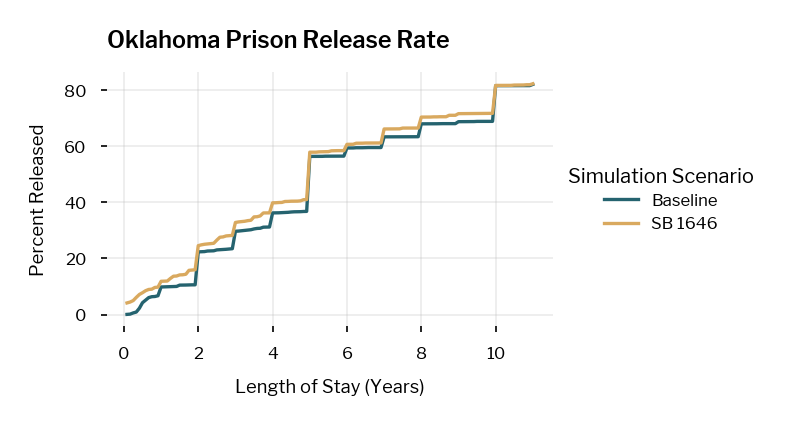

In [44]:
simulation_key = "policy"
compartment = "prison"
ax = None
for age, sub_sim in policy_sim.get_population_simulations()[
    simulation_key
].sub_simulations.items():
    spark_compartment = sub_sim.simulation_compartments[compartment]

    policy_ts = max(spark_compartment.compartment_transitions.transition_tables.keys())
    for (
        time_step,
        transition_df,
    ) in spark_compartment.compartment_transitions.transition_tables[
        policy_ts
    ].tables.items():
        unnormalized_transitions = TransitionTable._unnormalized_table(transition_df)
        plot_label = "SB 1646" if time_step == policy_ts else "Baseline"
        unnormalized_transitions.index = unnormalized_transitions.index / 12
        ax = (
            (
                100
                * unnormalized_transitions["release"].cumsum()
                / sum(unnormalized_transitions["release"])
            )
            .head(132)
            .plot(label=plot_label, ax=ax)
        )

add_legend(title="Simulation Scenario")
plt.ylabel("Percent Released")
plt.xlabel("Length of Stay (Years)")
plt.title("Oklahoma Prison Release Rate")

Text(0.0, 1.0, 'Oklahoma Prison Release Rate')

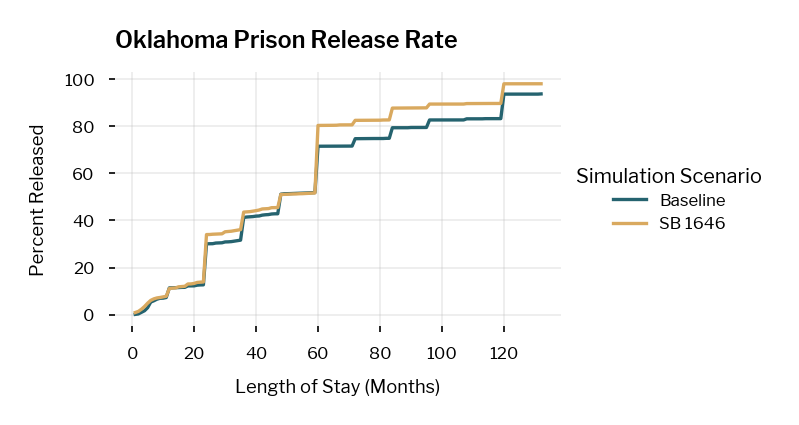

In [125]:
simulation_key = "policy"
compartment = "prison"
ax = None
for age, sub_sim in policy_sim.get_population_simulations()[
    simulation_key
].sub_simulations.items():
    spark_compartment = sub_sim.simulation_compartments[compartment]

    policy_ts = max(spark_compartment.compartment_transitions.transition_tables.keys())
    for (
        time_step,
        transition_df,
    ) in spark_compartment.compartment_transitions.transition_tables[
        policy_ts
    ].tables.items():
        unnormalized_transitions = TransitionTable._unnormalized_table(transition_df)
        plot_label = "SB 1646" if time_step == policy_ts else "Baseline"
        ax = (
            (
                100
                * unnormalized_transitions["release"].cumsum()
                / sum(unnormalized_transitions["release"])
            )
            .head(132)
            .plot(label=plot_label, ax=ax)
        )

add_legend(title="Simulation Scenario")
plt.ylabel("Percent Released")
plt.xlabel("Length of Stay (Months)")
plt.title("Oklahoma Prison Release Rate")

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 1531.05rows/s]


   total_population
8          0.022272
initialization time:  2.4396798610687256
initialization time:  2.3376781940460205
simulation_time:  2.801741123199463
simulation_time:  2.678166151046753
5269.0


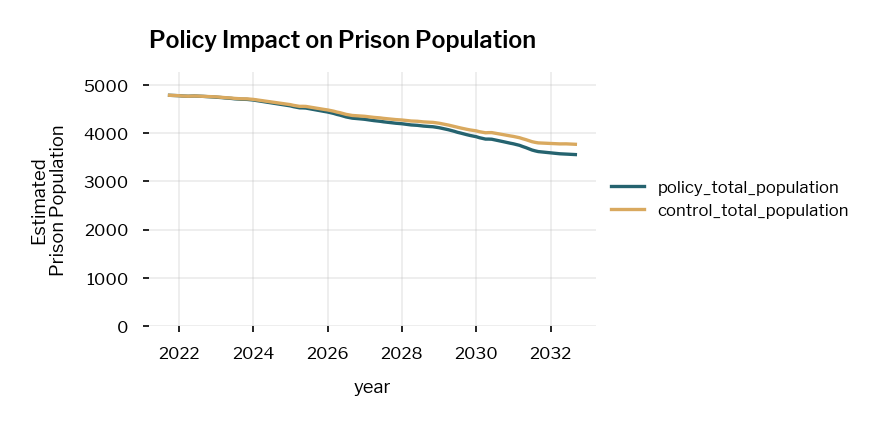

In [46]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/OK/OK_SB_1646_sentence_reclassification/OK_SB_1646_model_inputs_reclassified_statutes.yaml"
)
policy_transitions = pd.read_csv(
    "../state/OK/OK_SB_1646_sentence_reclassification/reclassified_statutes/trans_policy_reclass - trans_policy_reclass.csv"
)

policy_transitions.rename(
    {"new_sent": "compartment_duration", "n": "total_population"}, axis=1, inplace=True
)

alternate_policy_transitions = policy_transitions.copy()
alternate_policy_transitions["compartment_duration"] = np.floor(
    np.clip(alternate_policy_transitions["compartment_duration"], a_min=1, a_max=None)
)
alternate_policy_transitions = alternate_policy_transitions.groupby(
    ["compartment", "outflow_to", "compartment_duration", "crime_type"], as_index=False
)[["total_population"]].sum()
alternate_policy_transitions.head()

# Simulate policy starting July 1, 2022
policy_ts = 9

# Policy functions


def replace_sentencing_matrix():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_policy_transitions,
        retroactive=False,
    )


policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(),
        spark_compartment="prison",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
]

policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [47]:
simulation_tag = "OK_SB1646_reclassified_statutes"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 1153.82rows/s]


initialization time:  2.835162878036499
initialization time:  2.7787771224975586
simulation_time:  2.975152015686035
simulation_time:  2.943547010421753
4995.099999999999


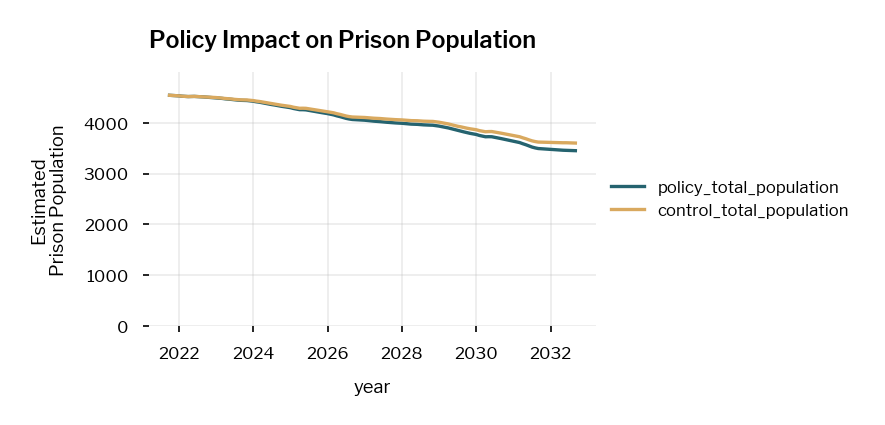

In [15]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/OK/OK_SB_1646_sentence_reclassification/OK_SB_1646_model_inputs_added_enhancements.yaml"
)
policy_transitions = pd.read_csv(
    "../state/OK/OK_SB_1646_sentence_reclassification/added_enhancements/trans_policy_enhancements - trans_policy_enhancements.csv"
)

policy_transitions.rename(
    {"new_sent": "compartment_duration", "n": "total_population"}, axis=1, inplace=True
)

alternate_policy_transitions = policy_transitions.copy()
alternate_policy_transitions["compartment_duration"] = np.floor(
    np.clip(alternate_policy_transitions["compartment_duration"], a_min=1, a_max=None)
)
alternate_policy_transitions = alternate_policy_transitions.groupby(
    ["compartment", "outflow_to", "compartment_duration", "crime_type"], as_index=False
)[["total_population"]].sum()
alternate_policy_transitions.head()

# Simulate policy starting July 1, 2022
policy_ts = 9

# Policy functions


def replace_sentencing_matrix():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_policy_transitions,
        retroactive=False,
    )


policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(),
        spark_compartment="prison",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
]

policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [16]:
simulation_tag = "OK_SB1646_added_enhancements"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 1245.13rows/s]


initialization time:  2.632268190383911
initialization time:  2.8231730461120605
simulation_time:  2.787047863006592
simulation_time:  2.8097310066223145
4950.000000000002


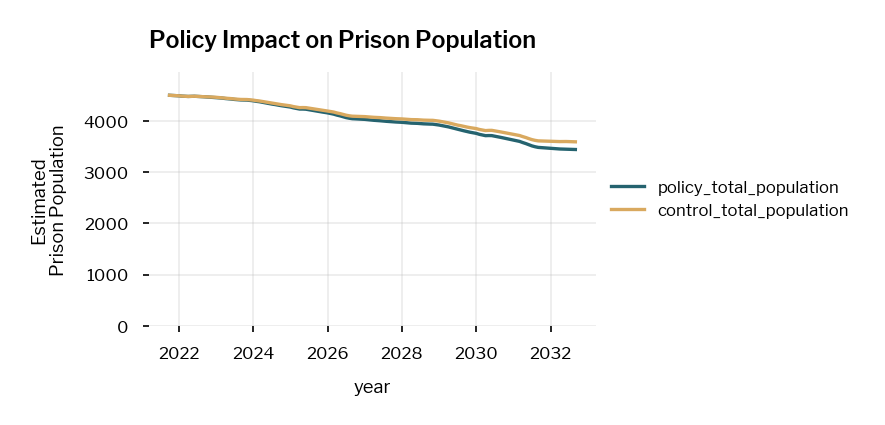

In [53]:
policy_sim = SuperSimulationFactory.build_super_simulation(
    "../state/OK/OK_SB_1646_sentence_reclassification/OK_SB_1646_model_inputs_hybrid.yaml"
)
policy_transitions = pd.read_csv(
    "../state/OK/OK_SB_1646_sentence_reclassification/hybrid/trans_policy_hybrid - trans_policy_hybrid.csv"
)

policy_transitions.rename(
    {"new_sent": "compartment_duration", "n": "total_population"}, axis=1, inplace=True
)

alternate_policy_transitions = policy_transitions.copy()
alternate_policy_transitions["compartment_duration"] = np.floor(
    np.clip(alternate_policy_transitions["compartment_duration"], a_min=1, a_max=None)
)
alternate_policy_transitions = alternate_policy_transitions.groupby(
    ["compartment", "outflow_to", "compartment_duration", "crime_type"], as_index=False
)[["total_population"]].sum()
alternate_policy_transitions.head()

# Simulate policy starting July 1, 2022
policy_ts = 9

# Policy functions


def replace_sentencing_matrix():
    return partial(
        TransitionTable.use_alternate_transitions_data,
        alternate_historical_transitions=alternate_policy_transitions,
        retroactive=False,
    )


policy_list = [
    SparkPolicy(
        policy_fn=replace_sentencing_matrix(),
        spark_compartment="prison",
        sub_population={"crime_type": "x"},
        policy_ts=policy_ts,
        apply_retroactive=False,
    ),
]

policy_results = policy_sim.simulate_policy(policy_list, "prison")
add_legend()

In [54]:
simulation_tag = "OK_SB1646_hybrid"
results_dict = policy_sim.upload_policy_simulation_results_to_bq(simulation_tag)

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/exporter.py:336: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_multipliers = cost_multipliers.append(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]
